In [8]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
# MNIST
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops

%matplotlib inline

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True 


# Convolutional Layer 1.
filter_size_1 = 5
num_filters_1 = 16

# Convolutional Layer 2
filter_size_2 = 5
num_filters_2 = 36

# Fully-connected layer.
fc_size = 128

In [9]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10


In [10]:
# 下载解压训练数据
mnist=input_data.read_data_sets("path/to/MNIST_data/",one_hot=True)
print(mnist.train.num_examples)
print(mnist.train.images.shape)
print(mnist.validation.num_examples)
print(mnist.validation.images.shape)
print(mnist.test.num_examples)

Extracting path/to/MNIST_data/train-images-idx3-ubyte.gz
Extracting path/to/MNIST_data/train-labels-idx1-ubyte.gz
Extracting path/to/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting path/to/MNIST_data/t10k-labels-idx1-ubyte.gz
55000
(55000, 784)
5000
(5000, 784)
10000


[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
<class 'numpy.ndarray'>


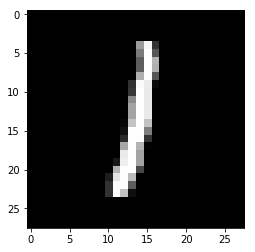

In [3]:
# 显示图片
plt.imshow(mnist.train.images[4].reshape(28,28),cmap=plt.cm.gray)
print(mnist.train.labels[4])
print(type(mnist.train.images))

In [4]:
def load_data_set(mnist):
    #X_train=tf.transpose(mnist.train.images)
#     Y_train=tf.transpose(mnist.train.labels)
#     X_dev=tf.transpose(mnist.validation.images)
#     Y_dev=tf.transpose(mnist.validation.labels)
#     X_test=tf.transpose(mnist.test.images)
#     Y_test=tf.transpose(mnist.test.labels)
    
    X_train=mnist.train.images.T
    Y_train=mnist.train.labels.T
    X_dev=mnist.validation.images.T
    Y_dev=mnist.validation.labels.T
    X_test=mnist.test.images.T
    Y_test=mnist.test.labels.T
    
    return X_train,Y_train,X_dev,Y_dev,X_test,Y_test

In [5]:
def create_placeholders(n_x,n_y):
    
    X=tf.placeholder(tf.float32,[n_x,None],name="X")
    Y=tf.placeholder(tf.float32,[n_y,None],name="Y")
    
    return X,Y

In [ ]:
def new_weights(shape):
    return tf.Variable(tf.truncated_no)

In [6]:
def initialize_parameters():
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [100, 784], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [100,1], initializer=tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [10, 100], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2",[10,1],initializer=tf.zeros_initializer())
    
    parameters={"W1":W1,
                "b1":b1,
                "W2":W2,
                "b2":b2}
    
    return parameters

In [7]:
def forward_propagation(X, parameters):
    
    A1=tf.nn.relu(tf.matmul(parameters["W1"],X)+parameters["b1"])
    Z2=tf.matmul(parameters["W2"],A1)+parameters["b2"]
    
    return Z2

In [8]:
def compute_cost(Z2,Y):
    
    logits = tf.transpose(Z2)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

In [9]:
def random_minibatches(X_train, Y_train, minibatch_size, seed=0):
    
    np.random.seed(seed)
    m=X_train.shape[1]
    mini_batches=[]
    
    permutation=list(np.random.permutation(int(m)))
    shuffled_X=X_train[:,permutation]
    shuffled_Y=Y_train[:,permutation]
    
    num_complete_minibatches=math.floor(m/minibatch_size)
    
    for i in range(num_complete_minibatches):
        
        minibatch_X=shuffled_X[:,i*minibatch_size:(i+1)*minibatch_size]
        minibatch_Y=shuffled_Y[:,i*minibatch_size:(i+1)*minibatch_size]
        # End code
        minibatch=(minibatch_X,minibatch_Y)
        mini_batches.append(minibatch)
        
    if m%minibatch_size != 0:
        last_minibatch_X=shuffled_X[:,num_complete_minibatches*minibatch_size:]
        last_minibatch_Y=shuffled_Y[:,num_complete_minibatches*minibatch_size:]
        last_minibatch=(last_minibatch_X,last_minibatch_Y)
        mini_batches.append(last_minibatch)
        
    return mini_batches

In [10]:
def model(X_train,Y_train,X_dev,Y_dev,learning_rate=0.0001,
          num_epochs=1000,minibatch_size=500,print_cost=True):
    
    ops.reset_default_graph() 
    tf.set_random_seed(1)
    seed = 1
    
    # 绘制曲线图
    costs_graph=[]
    validation_acc_graph=[]
    
    (n_x,m)=X_train.shape
    n_y=Y_train.shape[0]
    
    X, Y = create_placeholders(n_x,n_y)
    
    parameters=initialize_parameters()
    
    Z2=forward_propagation(X,parameters)
    
    cost = compute_cost(Z2,Y)
    
#     optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # 计算预测准确率, axis=0
    correct_prediction=tf.equal(tf.argmax(Z2,0),tf.argmax(Y,0))
    accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    
    # 保存计算模型
    saver=tf.train.Saver()
    
    init = tf.global_variables_initializer()
    

    with tf.Session(config=config) as sess:
        
        # run the initializer
        sess.run(init)
        
        for k in range(num_epochs):
            
            seed = seed + 1
            epoch_cost = 0
            
            minibatches=random_minibatches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y)=minibatch
                
                _,minibatch_cost=sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y}) 
                
                epoch_cost = minibatch_cost+epoch_cost
            
            if k%20==0:
                # 计算验证集的准确率
                validate_acc=sess.run(accuracy,feed_dict={X:X_dev,Y:Y_dev})
                
                # 输出损失函数和验证数据集的准确率
                print("Cost after epoch %i: %f" % (k,epoch_cost))
                print("Validation accuracy: %f" % validate_acc)
                
                # 记录绘图数据
                costs_graph.append(epoch_cost)
                validation_acc_graph.append(validate_acc)
        
        # 计算测试集的准确率
        test_acc=sess.run(accuracy,feed_dict={X:X_test,Y:Y_test})
        train_acc=sess.run(accuracy,feed_dict={X:X_train,Y:Y_train})
        validation_acc=sess.run(accuracy,feed_dict={X:X_dev,Y:Y_dev})
        print("Train accuracy is: %f" % train_acc)
        print("Validation accuracy is: %f" % validation_acc)
        print("Test accuracy is: %f" % test_acc)
        
        saver.save(sess,"model/nnmodel.ckpt")
    
    
    # plot the cost
    plt.subplot(2,1,1)
    plt.plot(np.squeeze(costs_graph))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("cost iterations")
    
    plt.subplot(2,1,2)
    plt.plot(np.squeeze(validation_acc_graph))
    plt.ylabel('validation accuracy')
    plt.xlabel('iterations')
    plt.title('accuracy iterations')
    
    plt.show()

In [11]:
#
X_train,Y_train,X_dev,Y_dev,X_test,Y_test=load_data_set(mnist)

print("train shape X:%s, Y:%s" % (str(X_train.shape),str(Y_train.shape)))
print("dev shape X:%s, Y:%s" % (str(X_dev.shape),str(Y_dev.shape)))
print("test shape X:%s, Y:%s" % (str(X_test.shape),str(Y_test.shape)))

train shape X:(784, 55000), Y:(10, 55000)
dev shape X:(784, 5000), Y:(10, 5000)
test shape X:(784, 10000), Y:(10, 10000)


In [12]:
# unit test for random_minibatches
X_train_test = np.zeros((784, 55000))
Y_train_test = np.zeros((10,55000))
print(type(X_train_test))
print(type(X_train))
mini_batches=random_minibatches(X_train_test,Y_train_test,5,seed=1)
print("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
shape of the 1st mini_batch_X: (784, 5)
shape of the 2nd mini_batch_X: (784, 5)
shape of the 3rd mini_batch_X: (784, 5)
shape of the 1st mini_batch_Y: (10, 5)
shape of the 2nd mini_batch_Y: (10, 5)
shape of the 3rd mini_batch_Y: (10, 5)


In [13]:
# cost function unit test
tf.reset_default_graph()

with tf.Session(config=config) as sess:
    X, Y = create_placeholders(784, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))
    

Z3 = Tensor("add_1:0", shape=(10, ?), dtype=float32)
cost = Tensor("Mean:0", shape=(), dtype=float32)


Cost after epoch 0: 278.610400
Validation accuracy: 0.953400
Cost after epoch 20: 4.830895
Validation accuracy: 0.976800
Cost after epoch 40: 2.832521
Validation accuracy: 0.978200
Cost after epoch 60: 0.045578
Validation accuracy: 0.980000
Cost after epoch 80: 1.363974
Validation accuracy: 0.973200
Train accuracy is: 1.000000
Validation accuracy is: 0.980400
Test accuracy is: 0.978800


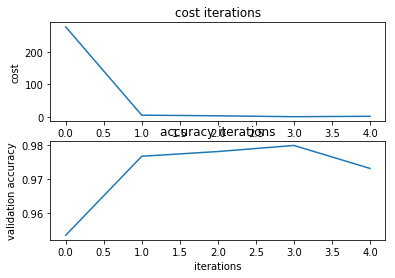

In [14]:
model(X_train,Y_train,X_dev,Y_dev,learning_rate=0.001,num_epochs=100,minibatch_size=64)
# AdamOptimizer(num_epochs=20): Train=0.998218, Validation=0.982600, Test=0.981200
# GradientDescentOptimizer: Train=0.887927, Validation=0.895200, Test=0.893300